In [ ]:
pwd

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [3]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            187           3         181           0           2         182
Swap:            11           0          11


In [4]:
!nvidia-smi

Tue Oct 26 11:54:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   40C    P0    71W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [5]:
import os
from datetime import datetime; now = datetime.now

analysis_name = 'CVAE_'+str(now())
save_dir = os.path.join('../Assets/tf_weights',analysis_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
print(analysis_name)

CVAE_2021-10-26 11:54:20.388923


In [6]:
# CHECK GPU
import nvidia_smi
try:
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

    print("Total memory:", (info.total/1024/1024/1024))
    print("Free memory:", (info.free/1024/1024/1024))
    print("Used memory:", (info.used/1024/1024/1024))

    nvidia_smi.nvmlShutdown()
except:
    pass

Total memory: 15.78173828125
Free memory: 15.7816162109375
Used memory: 0.0001220703125


In [7]:
## SET UP

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
from umap import UMAP
tqdm = partial(tqdm, position=0, leave=True) 

In [9]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [10]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
df = df.sort_values(by='bids_folder')
print(len(df))
#data_dir = '../Assets/fc_mats_32smooth_new/'
data_dir = '../Assets/abide_1_cmats'

1048


In [11]:
files = [file for file in os.listdir(data_dir) if file.endswith('.npy')]
files = np.array(files)
files.sort()
is_inDF = np.array([file.replace('.npy','') in df['bids_folder'].values for file in files])
files = files[is_inDF]

print(len(files))
files[0:5]

1048


array(['sub-CMUa0050642.npy', 'sub-CMUa0050646.npy',
       'sub-CMUa0050647.npy', 'sub-CMUa0050649.npy',
       'sub-CMUa0050653.npy'], dtype='<U23')

In [12]:
cmats = np.array([np.load(os.path.join(data_dir,file)) for file in files])
has_na = np.array([np.isnan(cmats[i,:,:]).sum()>0 for i in range(cmats.shape[0])])
assert has_na.sum()==0, 'nans in cmats'

In [13]:
assert len(df)==len(files),'mismatch'
assert all([df['bids_folder'].values[i]==files[i].replace('.npy','') for i in range(len(df))]), 'out of order'

In [14]:
%%time
from importlib import reload
import helper_funcs;reload(helper_funcs);from helper_funcs import *
del helper_funcs
import make_models;reload(make_models);from make_models import *
del make_models

from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns

import tensorflow as tf
reload(tf)

CPU times: user 47.4 ms, sys: 13.9 ms, total: 61.3 ms
Wall time: 229 ms


<module 'tensorflow' from '/data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/__init__.py'>

In [15]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
#data_dir = '../Assets/fc_mats_32smooth_new'
data_loader = cvae_data_loader(data_dir=data_dir, df=df, batch_size=32)
batch_asd,batch_td,batch_df = data_loader.get_batch()

In [19]:
data_size = np.hstack((len(df),batch_asd.shape[1:]))
data_size

array([1048,   51,   51])

In [20]:
def cvae_dashboard(red='PCA'):        
    #prediction = cvae.predict(patient_batch)    
    predictions = cvae.predict([patient_batch,control_batch])
    sigma = (np.e ** z_encoder.predict(patient_batch)[1]).mean()
    sigmas.append(sigma)

    mu = z_encoder.predict(patient_batch)[0]
    mus.append(np.mean([mu[:,0].std() for i in range(mu.shape[1])]))

    prediction = predictions[0]

    cmat_actual = np.corrcoef(np.vstack((patient_batch.reshape(patient_batch.shape[0],-1),control_batch.reshape(control_batch.shape[0],-1))))
    cmat_pred = np.corrcoef(np.vstack((predictions[0].reshape(predictions[0].shape[0],-1),predictions[1].reshape(predictions[1].shape[0],-1))))
    c_sim.append(np.corrcoef(get_triu(cmat_pred),get_triu(cmat_actual))[0,1])


    ### PROGRESS PLOTTING
    display.clear_output(wait=True);
    display.display(plt.gcf());
    #Organise figure
    ncols = 4;nrows=7
    if np.mod(i,5)==0:
        plt.close()
    plt.subplots(nrows,ncols,figsize=(15,15)); # MAKE THE FIGURE


    ##### SUBPLOT 1 & 2 ##### 

    plt.subplot(nrows,ncols/2,1) # PLOT LOSS
    xs = np.arange(len(loss))+1
    m,b = np.polyfit(xs,loss,deg=1)
    plt.plot(loss)
    plt.plot(xs, m*xs + b)
    plt.title(f'Epoch {data_loader.epoch} batch {data_loader.b}/{data_loader.n_batches} | Loss {loss[-1]:.2f}, beta: {m:.4f}')

    ##### SUBPLOT 3 ##### 
    plt.subplot(nrows,ncols,3) # PLOT LOSS LAST 50
    hb = 50
    if len(loss)>hb:
        plot_loss = loss[-hb::]
        xs = np.arange(len(plot_loss))
        m,b = np.polyfit(xs,plot_loss,deg=1)
        plt.plot(plot_loss)
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'Loss last {hb} it, beta {m:.4f}')

    ##### SUBPLOT 4 ##### 
    plt.subplot(nrows,ncols,4)
    plt.hist(prediction[0,:,:,0].flatten(),alpha=.5)
    plt.hist(patient_batch[0,:,:].flatten(),alpha=.5)
    plt.legend(['predicted','actual'])
    plt.title('in/out histograms')

    ##### SUBPLOT 5 ##### 
    plt.subplot(nrows,ncols,5) #RSA over time
    plt.plot(c_sim)
    plt.title(f'in/out RSA: {c_sim[-1].round(2)}')

    if len(c_sim)>5: # PLOT LS LINE
        xs = np.arange(len(c_sim))+1
        m,b = np.polyfit(xs,c_sim,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'in/out RSA: {c_sim[-1].round(2)}, b={m:.4f}')


    ##### SUBPLOT 6 ##### 
    plt.subplot(nrows,ncols,6)
    if len(c_sim)>hb:
        #plot_loss = loss[-hb::]
        xs = np.arange(len(c_sim[-hb::]))
        m,b = np.polyfit(xs,c_sim[-hb::],deg=1)
        plt.plot(c_sim[-hb::])
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'in/outRSA last {hb} it, b={m:.4f}')

    # ##### SUBPLOT 7 ##### 
    # plt.subplot(nrows,ncols,7)
    # lbls = ['age','sex','fiq','dsm','site','ados'];
    # xs = np.arange(len(lbls));
    # plt.bar(xs,batch_rsas[0:6]);
    # plt.xticks(xs,labels=lbls);
    # plt.title('S RSA')

    # ##### SUBPLOT 8 ##### 
    # plt.subplot(nrows,ncols,8)
    # lbls = ['age','sex','fiq','dsm','site','ados'];
    # xs = np.arange(len(lbls));
    # plt.bar(xs,batch_rsas[6::]);
    # plt.xticks(xs,labels=lbls);
    # plt.title('Z RSA')


    ##### SUBPLOT 9 ##### 
    plt.subplot(nrows,ncols,9)
    plt.plot(sigmas)
    plt.title(f'sigmas | {sigmas[-1]:.4f}')


    ##### SUBPLOT 10 ##### 
    plt.subplot(nrows,ncols,10)
    plt.plot(mus)
    plt.title(f'Mu variance {mus[-1]:.4f}')


    ##### SUBPLOT 11 ##### 
    plt.subplot(nrows,ncols,11)
    sns.heatmap(cmat_actual,xticklabels=[],yticklabels=[])
    plt.title('input RSA')

    ##### SUBPLOT 12 ##### 
    plt.subplot(nrows,ncols,12)
    sns.heatmap(cmat_pred,xticklabels=[],yticklabels=[])
    plt.title('output RSA')

    # #############################################
    # ###################Reconstructions###########
    # #############################################

    ##### SUBPLOT 13 #####     
    rand_sub = np.random.randint(low=0,high=patient_batch.shape[0])

    plt.subplot(nrows,ncols,13)
    sns.heatmap(patient_batch[rand_sub,:,:])
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 14 #####     
    plt.subplot(nrows,ncols,14)
    sns.heatmap(prediction[rand_sub,:,:,0])
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    # ##### SUBPLOT 15 #####     
    plt.subplot(nrows,ncols,15)
    sns.heatmap(abs(patient_batch[rand_sub,:,:]-prediction[rand_sub,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('difference')


    # ##### SUBPLOT 16 #####                                             
    # plt.subplot(nrows,ncols,16)
    # plt.imshow(np.rot90(prediction[rand_sub,16,:,:,rand_map]))
    # plt.xticks([]);plt.yticks([]);plt.title('predicted')
    # ##### SUBPLOT 17 #####     
    # plt.subplot(nrows,ncols,17)
    # plt.imshow(np.rot90(patient_batch[rand_sub,6,:,:,rand_map]))
    # plt.xticks([]);plt.yticks([]);plt.title('actual')
    # ##### SUBPLOT 18 #####                                             
    # plt.subplot(nrows,ncols,18)
    # plt.imshow(np.rot90(prediction[rand_sub,6,:,:,rand_map]))
    # plt.xticks([]);plt.yticks([]);plt.title('predicted')
    # ##### SUBPLOT 19 #####     
    # plt.subplot(nrows,ncols,19)
    # plt.imshow(patient_batch[rand_sub,:,:,16,rand_map])
    # plt.xticks([]);plt.yticks([]);plt.title('actual')
    # ##### SUBPLOT 20 #####     
    # plt.subplot(nrows,ncols,20)
    # plt.imshow(prediction[rand_sub,:,:,16,rand_map])
    # plt.xticks([]);plt.yticks([]);plt.title('predicted')


    # #############################################
    # ################### LOSSES ##################
    # #############################################


    predictions = cvae.predict([patient_batch,control_batch])
    input_shape = data_size[1:]
    reconstruction_loss = tf.keras.losses.mse(K.flatten(patient_batch), K.flatten(predictions[0])) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(control_batch), K.flatten(predictions[1])) 
    reconstruction_loss *= input_shape[0] * input_shape[1]


    tg_z_mean, tg_z_log_var, tg_z = z_encoder.predict(patient_batch)
    tg_s_mean, tg_s_log_var, tg_s = s_encoder.predict(patient_batch)

    bg_z_mean, bg_z_log_var, bg_z = z_encoder.predict(control_batch)

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)
    kl_loss = kl_loss1+kl_loss2+kl_loss3
    kl_loss *= -0.5


    discriminator = Dense(1, activation='sigmoid')
    z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
    z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
    s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
    s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

    q_bar = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z2], axis=1),
      tf.keras.layers.concatenate([s2, z1], axis=1)],
      axis=0)

    q = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z1], axis=1),
      tf.keras.layers.concatenate([s2, z2], axis=1)],
      axis=0)

    q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
    q_score = (discriminator(q)+.1) *.85 
    tc_loss = K.log(q_score / (1 - q_score)) 
    discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    discriminator_loss

    loss_mse.append(reconstruction_loss.numpy())
    loss_kl.append(kl_loss.numpy().mean())
    loss_dc.append(tc_loss.numpy().mean())
    loss_tc.append(discriminator_loss.numpy().mean())


    plt.subplot(nrows,ncols,21) # MSE 
    plt.plot(loss_mse)
    plt.title(f'MSE | {loss_mse[-1]:.4f}')

    plt.subplot(nrows,ncols,22) # KL loss
    plt.plot(loss_kl)
    plt.title(f'KL | {loss_kl[-1]:.4f}')    


    plt.subplot(nrows,ncols,23) # TC     
    plt.plot(loss_tc)
    plt.title(f'Total Correlation loss | {loss_tc[-1]:.4f}')    


    plt.subplot(nrows,ncols,24) # Disc         
    plt.plot(loss_dc)
    plt.title(f'discriminator_loss | {loss_dc[-1]:.4f}')    


    tg_s = s_encoder.predict(patient_batch)
    tg_z = z_encoder.predict(patient_batch)
    bg_z = z_encoder.predict(control_batch)

    plt.subplot(nrows,ncols,25)
    plt.hist(tg_s[2].flatten(),alpha=.5);
    plt.hist(tg_z[2].flatten(),alpha=.5);
    plt.hist(bg_z[2].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Z')


    plt.subplot(nrows,ncols,26)
    plt.hist(tg_s[0].flatten(),alpha=.5);
    plt.hist(tg_z[0].flatten(),alpha=.5);
    plt.hist(bg_z[0].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Mus')


    plt.subplot(nrows,ncols,27)
    plt.hist(tg_s[1].flatten(),alpha=.5);
    plt.hist(tg_z[1].flatten(),alpha=.5);
    plt.hist(bg_z[1].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Sigmas')

    plt.tight_layout()
    plt.show()
    sys.stdout.flush()

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import os
import pandas as pd

def get_fMRI_CVAE_3D(input_shape=(51,51,1),
                     latent_dim=[2,2],
                     beta=1,
                     disentangle=False,
                     gamma=1,
                     bias=True,
                     batch_size = 32,
                     kernel_size = 3,
                     filters = 16,
                     intermediate_dim = 128,
                     nlayers = 2,
                     learning_rate=0.001,
                     opt=None):
    
    
    ndim_bg = latent_dim[0]
    ndim_sl = latent_dim[1]
    
    image_size, _, channels = input_shape

    kernel_regularizer=regularizers.l2(.0001)

    # build encoder model
    tg_inputs = Input(shape=input_shape, name='tg_inputs')
    bg_inputs = Input(shape=input_shape, name='bg_inputs')
    
    BatchNorm = tf.keras.layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones', beta_regularizer=None,
    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    #kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,stddev=5)
    kernel_initializer = tf.keras.initializers.RandomUniform()

    # generate latent vector Q(z|X)
    
    
    z_h_layer = Dense(intermediate_dim,activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_mean_layer = Dense(ndim_bg, name='z_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_log_var_layer = Dense(ndim_bg, name='z_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_layer = Lambda(sampling, output_shape=(ndim_bg,), name='z')

    def z_encoder_func(inputs):
        z_h = inputs

        these_filters = filters
        for i in range(nlayers):
            these_filters *= 2
            #print(these_filters)
            z_h = Conv2D(filters=these_filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    padding='same',
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer)(z_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(z_h)
        z_h = Flatten()(z_h)
        z_h = z_h_layer(z_h)
        z_mean =  z_mean_layer(z_h)
        #z_mean = BatchNorm(z_mean)
        
        z_log_var =  z_log_var_layer(z_h)
        z = z_layer([z_mean, z_log_var])
        return z_mean, z_log_var, z, shape

    tg_z_mean, tg_z_log_var, tg_z, shape_z = z_encoder_func(tg_inputs)

    # generate latent vector Q(z|X)
    s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_mean_layer = Dense(ndim_sl, name='s_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_log_var_layer = Dense(ndim_sl, name='s_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_layer = Lambda(sampling, output_shape=(ndim_sl,), name='s')

    def s_encoder_func(inputs):
        s_h = inputs
        these_filters = filters
        for i in range(nlayers):
            these_filters *= 2
            s_h = Conv2D(filters=these_filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer,
                    padding='same')(s_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(s_h)
        s_h = Flatten()(s_h)
        s_h = s_h_layer(s_h)
        s_mean =  s_mean_layer(s_h)
        #s_mean = BatchNorm(s_mean)
        
        s_log_var =  s_log_var_layer(s_h)        
        s = s_layer([s_mean, s_log_var])
        
        return s_mean, s_log_var, s, shape

    tg_s_mean, tg_s_log_var, tg_s, shape_s = s_encoder_func(tg_inputs)
    bg_z_mean, bg_z_log_var, bg_z, _ = z_encoder_func(bg_inputs) # Aidas and Stefano team hax
    
    
    # instantiate encoder models
    z_encoder = tf.keras.models.Model(tg_inputs, [tg_z_mean, tg_z_log_var, tg_z], name='z_encoder')
    s_encoder = tf.keras.models.Model(tg_inputs, [tg_s_mean, tg_s_log_var, tg_s], name='s_encoder')


    # build decoder model
    latent_inputs = Input(shape=(ndim_bg+ndim_sl,), name='z_sampling')

    x = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(latent_inputs)
    x = Dense(shape_z[1] * shape_z[2] * shape_z[3], activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(x)
    x = Reshape((shape_z[1], shape_z[2], shape_z[3]))(x)

    these_filters = filters*(2**nlayers)/2
    for i in range(nlayers-1):
        x = Conv2DTranspose(filters=these_filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=2,
                          use_bias=bias,
                          kernel_regularizer=kernel_regularizer,
                          padding='same')(x)
        these_filters //= 2

    outputs = Conv2DTranspose(filters=channels,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            strides=2,
                            use_bias=bias,
                            kernel_regularizer=kernel_regularizer,
                            name='decoder_output')(x)

    # instantiate decoder model
    cvae_decoder = Model(latent_inputs, outputs, name='decoder')
      # decoder.summary()

    def zeros_like(x):
        return tf.zeros_like(x)

    tg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, tg_s], -1))
    zeros = tf.keras.layers.Lambda(zeros_like)(tg_s)

    bg_outputs = cvae_decoder(tf.keras.layers.concatenate([bg_z, zeros], -1)) # Aidas look into this, is this correct

    cvae = tf.keras.models.Model(inputs=[tg_inputs, bg_inputs], 
                                  outputs=[tg_outputs, bg_outputs],
                                  name='contrastive_vae')

#     cvae_fg = tf.keras.models.Model(inputs=tg_inputs, 
#                                   outputs=fg_outputs, 
#                                   name='contrastive_vae_fg')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
        s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

        q_bar = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z2], axis=1),
          tf.keras.layers.concatenate([s2, z1], axis=1)],
          axis=0)

        q = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z1], axis=1),
          tf.keras.layers.concatenate([s2, z2], axis=1)],
          axis=0)

        q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
        q_score = (discriminator(q)+.1) *.85 
        tc_loss = K.log(q_score / (1 - q_score)) 
        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    else:
        tc_loss = 0
        discriminator_loss = 0


    reconstruction_loss = tf.keras.losses.mse(K.flatten(tg_inputs), K.flatten(tg_outputs)) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(bg_inputs), K.flatten(bg_outputs)) 
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)

    kl_loss = kl_loss1+kl_loss2+kl_loss3
    #kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    cvae_loss = tf.keras.backend.mean(reconstruction_loss + beta*kl_loss + gamma*tc_loss + discriminator_loss)
    cvae.add_loss(cvae_loss)
    
    if type(opt)==type(None):
        #print('optimizer not specified using ADAM, wroom wroom')
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')
        #opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False, name='RMSprop')
        #opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1, nesterov=False, name='SGD')


    cvae.compile(optimizer=opt,run_eagerly=True)
    
    return cvae, z_encoder, s_encoder, cvae_decoder

In [22]:
#import make_models;reload(make_models);from make_models import *
batch_size = 32

cvae, z_encoder, s_encoder, cvae_decoder = get_fMRI_CVAE_3D(input_shape=(48,48,1),
                                                             latent_dim=[8,8],
                                                             beta=1,
                                                             gamma=1,
                                                             disentangle=True,
                                                             bias=True,
                                                             batch_size = batch_size,
                                                             kernel_size = 3,
                                                             filters = 8,
                                                             intermediate_dim = 256,
                                                             nlayers = 4,
                                                             learning_rate=0.001,
                                                             opt=None)

num_params = np.sum([np.prod(val.get_shape()) for val in cvae.trainable_weights])
print(f'# params| {num_params:,}')

# params| 1,287,474


In [23]:
tuple(data_size)

(1048, 51, 51)

In [24]:
z_encoder.summary(line_length=150)

Model: "z_encoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 48, 48, 1)]              0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                  (None, 24, 24, 16)               160               tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                                (None, 12, 12, 32)        

In [25]:
s_encoder.summary(line_length=150)

Model: "s_encoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 48, 48, 1)]              0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d_4 (Conv2D)                                (None, 24, 24, 16)               160               tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv2d_5 (Conv2D)                                (None, 12, 12, 32)        

In [26]:
cvae_decoder.summary(line_length=150)

Model: "decoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
z_sampling (InputLayer)                                            [(None, 16)]                                                0                      
______________________________________________________________________________________________________________________________________________________
dense_2 (Dense)                                                    (None, 256)                                                 4352                   
______________________________________________________________________________________________________________________________________________________
dense_3 (Dense)                                                    (None, 115

In [27]:
loss,all_rsas,sigmas,mus,c_sim = [],[],[],[],[]

In [28]:
loss_mse,loss_kl,loss_dc,loss_tc = [],[],[],[]

In [29]:
data_loader = cvae_data_loader(data_dir=data_dir, df=df, batch_size=batch_size)

In [35]:
data_loader.n_batches

16

<Figure size 432x288 with 0 Axes>

<ipython-input-20-98e29bd0068d>:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1) # PLOT LOSS


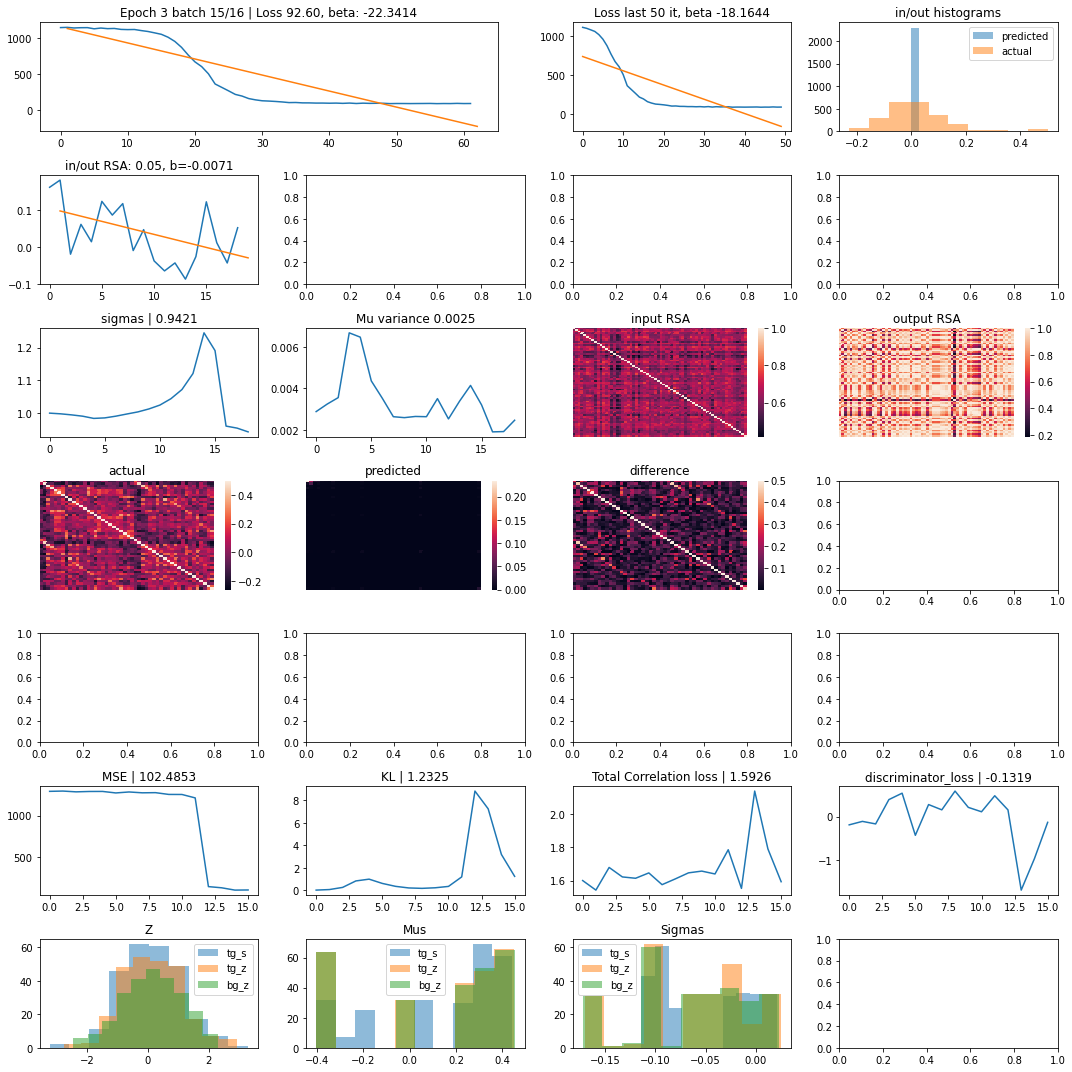

In [ ]:
#for epoch in tqdm(range(100),position=1, leave=True):
for epoch in range(100):
    for i in range(data_loader.n_batches):
        
        patient_batch,control_batch,batch_df = data_loader.get_batch() # Get a batch
        patient_batch = patient_batch[:,0:48,:][:,:,0:48]
        control_batch = control_batch[:,0:48,:][:,:,0:48]
        #hist = cvae.train_on_batch([patient_batch,control_batch]) # pass a batch
        hist = cvae.train_on_batch([patient_batch[:,:,:,np.newaxis],control_batch[:,:,:,np.newaxis]]) # pass a batch
        assert not np.isnan(hist),'loss is NaN - you f**cked up'  # check nothing crashed
        loss.append(hist) # keep track of loss
        
        cvae.save_weights(os.path.join(save_dir,'cvae_weights')) # SAVE WEIGHTS
        np.save(os.path.join(save_dir,'cvae_loss.npy'),np.array(loss)) # Save loss
        
        if all((np.mod(i,15)==0,np.mod(epoch,5)==0)):
            cvae_dashboard() # plot training progress
            #plt.show()
        

In [ ]:
cvae.summary(line_length=150)